## Baseline Model Pipeline   

Hi, I am aster - The kaggle bot to generate baseline kernels for a variety of datasets. In this kernel, I am using the given dataset for exploration, preprocessing, modelling purposes. Let me walk you through the contents of this kernel:

### Contents 

1. Environment Preparation
2. Quick Exploration   
&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Load Dataset    
&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Dataset Snapshot and Summary    
&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Target Variable Distribution    
&nbsp;&nbsp;&nbsp;&nbsp; 2.4 Missing Values    
&nbsp;&nbsp;&nbsp;&nbsp; 2.5 Variable Types  
&nbsp;&nbsp;&nbsp;&nbsp; 2.6 Variable Correlations
3. Preprocessing  
&nbsp;&nbsp;&nbsp;&nbsp; 3.1 Label Encoding    
&nbsp;&nbsp;&nbsp;&nbsp; 3.2 Missing Values Treatment     
&nbsp;&nbsp;&nbsp;&nbsp; 3.3 Feature Engineering   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.1 TF-IDF Vectorizor  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.2 Top Keywords - Wordcloud    
&nbsp;&nbsp;&nbsp;&nbsp; 3.4 Train Test Split    
4. Modelling   
&nbsp;&nbsp;&nbsp;&nbsp; 4.1 Logistic Regression  
&nbsp;&nbsp;&nbsp;&nbsp; 4.2 Decision Tree    
&nbsp;&nbsp;&nbsp;&nbsp; 4.3 Random Forest  
&nbsp;&nbsp;&nbsp;&nbsp; 4.4 ExtraTrees Classifier  
&nbsp;&nbsp;&nbsp;&nbsp; 4.5 Extereme Gradient Boosting  
5. Feature Importance   
6. Model Ensembling  
&nbsp;&nbsp;&nbsp;&nbsp; 6.1 A simple Blender  
7. Creating Submission

## Step 1: Prepare Environment
As the first step, lets load all the required libraries to be used in the kernel

In [50]:
## modelling libraries
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

## preprocessing libraries
from collections import Counter
import xgboost as xgb
import pandas as pd
import numpy as np 
import itertools

## visualization libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

print ("Cool, all libraries imported successfully")

Cool, all libraries imported successfully


## Step 2: Quick Exploration
As the next step, lets load the dataset into my memory and perform a quick exploratory analysis 

### 2.1 Dataset Preparation

In [51]:
## read dataset
train_df = pd.read_csv('../input/train.csv')
train_copy = train_df.copy()

## since test data is not present in some datasets, so lets use use exceptions
try: 
    test_df = pd.read_csv("../input/test.csv")
except Exception as E:
    test_df = pd.DataFrame()
    
print ("dataset loaded")

dataset loaded


get predictor and target variables

In [52]:
## get predictor and target variables
_target = "Survived"
Y = train_df[_target]
distinct_Y = Y.value_counts().index

_id = "PassengerId"
if _id == "": ## if no id is present, lets create a dummy 
    train_df['id'] = 1
    test_df['id'] = 1
    _id = "id"

drop id and target columns 

In [53]:
## drop the target and id columns
test_id = test_df[_id]
train_df = train_df.drop([_target, _id], axis=1)
test_df = test_df.drop([_id], axis=1)

## flag variables (used by bot to write the relevant code)
textcol = "text"
tag = "num"

### 2.2 Dataset snapshot and summary

lets look at the dataset snapshot and the summary

In [54]:
## snapshot of train and test
train_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [55]:
## summary of train and test
train_df.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


### 2.3 Target variable distribution

plot the distribution of target variable

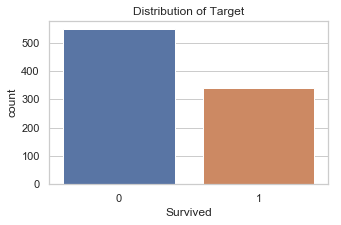

In [56]:
tar_dist = dict(Counter(Y.values))

xx = list(tar_dist.keys())
yy = list(tar_dist.values())

plt.figure(figsize=(5,3))
sns.set(style="whitegrid")
ax = sns.barplot(x=xx, y=yy)
ax.set_title('Distribution of Target')
ax.set_ylabel('count');
ax.set_xlabel(_target);

### 2.3 Missing Value Counts 

plot the missing values count 

there are 3 columns in the dataset having missing values


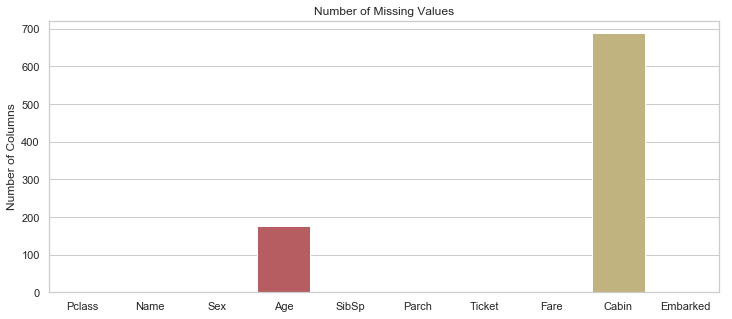

In [63]:
mcount = train_df.isna().sum() 
xx = mcount.index 
yy = mcount.values

plt.figure(figsize=(12,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=xx, y=yy)
ax.set_title('Number of Missing Values')
ax.set_ylabel('Number of Columns');

missing_cols = 0
for each in yy:
    if each > 0:
        missing_cols += 1
print ("there are " + str(missing_cols) + " columns in the dataset having missing values")

### 2.4 Variable Types

Lets count the number of numerical and categorical columns in the dataset

In [64]:
## find categorical columns in the dataset 
num_cols = train_df._get_numeric_data().columns
cat_cols = list(set(train_df.columns) - set(num_cols))

print ("There are " + str(len(num_cols)) + " numerical columns in the dataset")
print ("There are " + str(len(cat_cols)) + " object type columns in the dataset")

There are 5 numerical columns in the dataset
There are 5 object type columns in the dataset


### 2.5 Variable Correlations (Only Numerical Fields)

Lets plot the correlations among the variables. The generated graph can give an idea about features which are highly, moderately or least correlated with one another.  

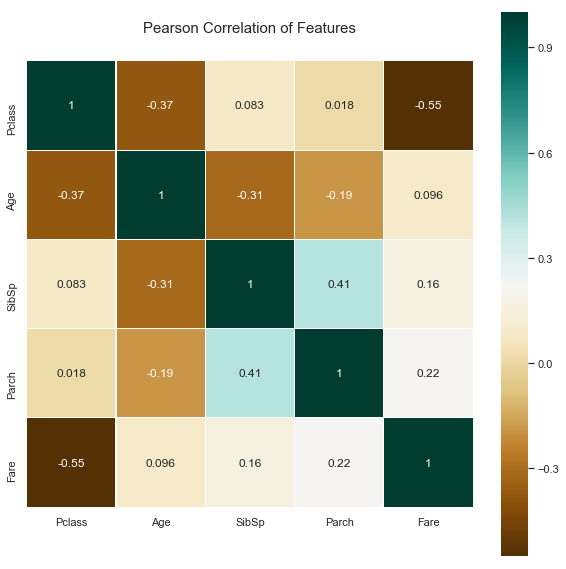

In [65]:
if tag != "doc":
    colormap = plt.cm.BrBG
    plt.figure(figsize=(10,10));
    plt.title('Pearson Correlation of Features', y=1.05, size=15);
    sns.heatmap(train_df.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);
else:
    print ("No variables available for correlation")

## Step 3: Data Preprocessing

In the data preprocessing step, we will perform label encoding of categorical variables and handle missing values.

### 3.1 Label Encoding
In this step, convert the categorical variables into label encoded forms

In [66]:
if tag != "doc":
    columns = train_df.columns
    num_cols = train_df._get_numeric_data().columns
    cat_cols = list(set(columns) - set(num_cols))

    for col in cat_cols: 
        le = LabelEncoder()
        le.fit(list(train_df[col].values) + list(test_df[col].values))
        train_df[col] = le.transform(list(train_df[col].values))
        try:
            test_df[col] = le.transform(list(test_df[col].values))
        except:
            pass
        
if Y.dtype.name == "object":
    le = LabelEncoder()
    Y = le.fit_transform(Y.values)

### 3.2 Missing Values Treatment

Handle the missing values, for continuous variables, replace by mean. For categorical variables, replace by mode

In [67]:
if tag != "doc":
    ## for numerical columns, replace the missing values by mean
    train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].mean())
    try:
        test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].mean())
    except:
        pass 
    
    ## for categorical columns, replace the missing values by mode
    train_df[cat_cols] = train_df[cat_cols].fillna(train_df[cat_cols].mode())
    
    try:
        test_df[cat_cols] = test_df[cat_cols].fillna(test_df[cat_cols].mode())
    except:
        pass

### 3.3 Feature Engineering (only for text fields)

In this section, we will create relevant features which can be used in the modelling

#### 3.1 Tf IDF features

In [68]:
if tag == "doc":
    tfidf = TfidfVectorizer(min_df=3,  max_features=None, analyzer='word', 
                            token_pattern=r'\w{1,}', stop_words = 'english')
    tfidf.fit(list(train_df[textcol].values))
    xtrain = tfidf.transform(train_df[textcol].values) 
    
    try:
        xtest = tfidf.transform(test_df[textcol].values)
    except:
        pass
else:
    xtrain = train_df
    xtest = test_df

Lets visualize top keywords for every target class

KeyError: 'text'

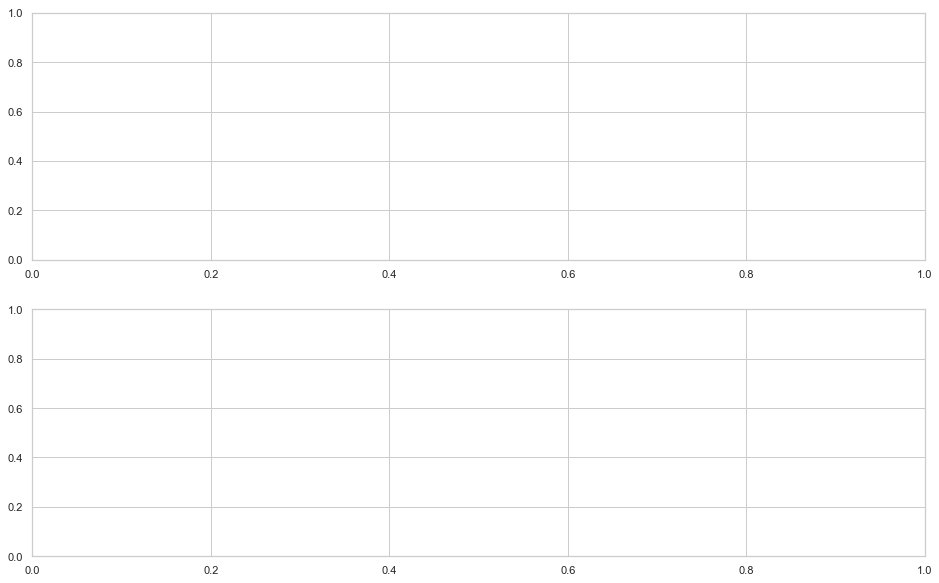

In [69]:
txts = []
fig, axes = plt.subplots(len(distinct_Y), 1, figsize=(16, 10))
for i, y in enumerate(distinct_Y):
    txt = " ".join(train_copy[train_copy[_target] == y]["text"]).lower()
    wordcloud1 = WordCloud(stopwords=STOPWORDS, background_color='white').generate(txt)
    
    ax = axes[i]
    ax.imshow(wordcloud1)
    ax.axis('off');
    ax.set_title(y, fontsize=10);

In [ ]:
sns.pairplot(train_df, palette="husl")

### 3.4 Train and Validation sets split

Create the training and validation sets for training the model and validating it

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(xtrain, Y, test_size=0.20, random_state=2018)

## Step 4 : Create baseline model

Next step is the modelling step, lets start with the simple linear model 

### 4.1 : Logistic Regression

Train a binary classifier logistic regression

The AUC for logistic regression is : 0.8098505434782608


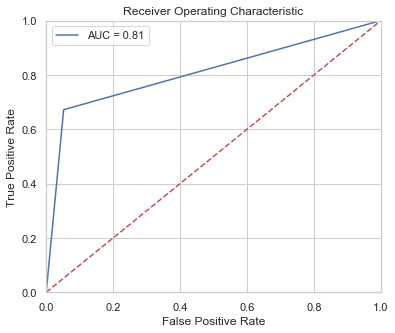

In [71]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)
valp = model1.predict(X_valid)

def generate_auc(y_valid, valp, model_name):
    auc_scr = roc_auc_score(y_valid, valp)
    print('The AUC for ' +model_name+ ' is :', auc_scr)

    fpr, tpr, thresholds = roc_curve(y_valid, valp)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'upper left')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## will only plot auc roc if the target is binary
try:
    generate_auc(y_valid, valp, model_name="logistic regression")
except:
    pass

<Figure size 576x576 with 0 Axes>

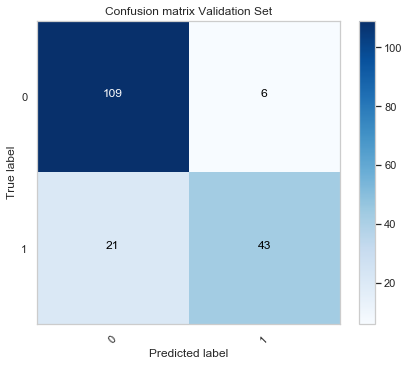

In [72]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,5));
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set')
plt.show()

### 4.2 : Decision Tree Classifier

Lets train a decision tree classifier

The AUC for decision tree classifier is : 0.7715353260869565


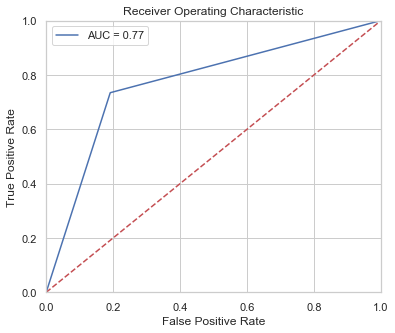

In [73]:
model2 = DecisionTreeClassifier()
model2.fit(X_train, y_train)
valp = model2.predict(X_valid)

## will only plot auc roc if the target is binary
try:
    generate_auc(y_valid,valp, model_name="decision tree classifier")
except:
    pass

<Figure size 432x360 with 0 Axes>

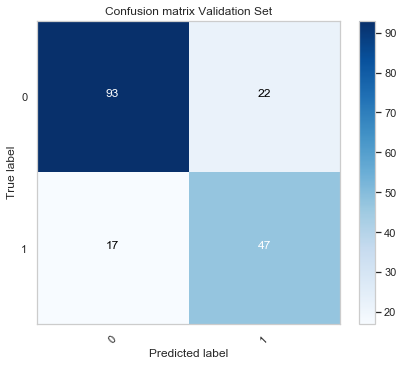

In [74]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,5));
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set');
plt.show();

try:
    import graphviz 
    dot_data = tree.export_graphviz(model, out_file=None, filled=True, rounded=True, 
                                    special_characters=True, feature_names = train_df.columns) 
    graph = graphviz.Source(dot_data)
    graph
except:
    pass

### 4.3 : Random Forest Classifier

Now, lets train a tree based model : random forest

The AUC for random forest classifier is : 0.7968070652173913


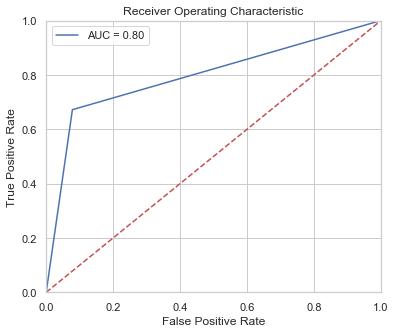

In [75]:
model3 = RandomForestClassifier()
model3.fit(X_train, y_train)
valp = model3.predict(X_valid)

## will only plot auc roc if the target is binary
try:
    generate_auc(y_valid,valp, model_name="random forest classifier")
except:
    pass

<Figure size 432x360 with 0 Axes>

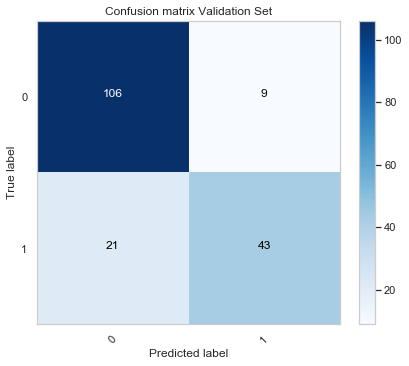

In [76]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,5));
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set');
plt.show();

### 4.4 : ExtraTrees Classifier

Now, lets train another tree based model : extra trees classifier

The AUC for extratrees classifier is : 0.7976902173913043


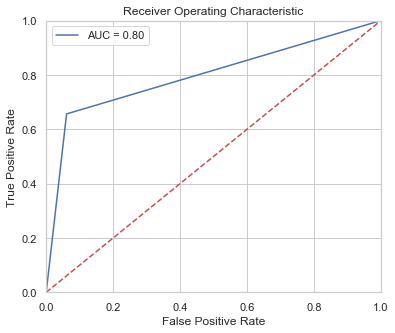

In [77]:
model4 = ExtraTreesClassifier()
model4.fit(X_train, y_train)
valp = model4.predict(X_valid)

## will only plot auc roc if the target is binary
try:
    generate_auc(y_valid,valp, model_name="extratrees classifier")
except:
    pass

<Figure size 432x360 with 0 Axes>

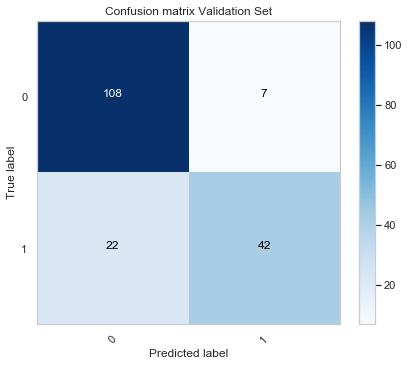

In [78]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,5));
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set');
plt.show();

### 4.5 : xgBoost Classifier

Lets train the extereme gradient boosting : xgboost classifier

The AUC for xgboost is : 0.7699048913043478


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


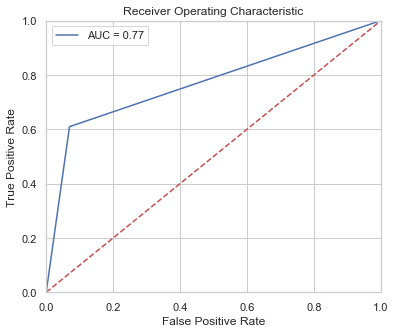

In [79]:
model5 = xgb.XGBClassifier(n_estimators=300, learning_rate=0.01)
model5.fit(X_train, y_train)
valp = model5.predict(X_valid)

## will only plot auc roc if the target is binary
try:
    generate_auc(y_valid,valp, model_name="xgboost")
except:
    pass

<Figure size 432x360 with 0 Axes>

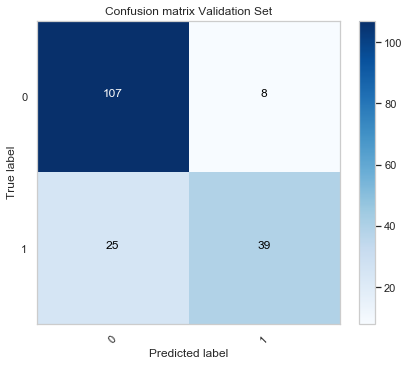

In [80]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,5))
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set')
plt.show()

## Step 5: Feature Importance

Lets look at some of the important features from the dataset

<Figure size 864x576 with 0 Axes>

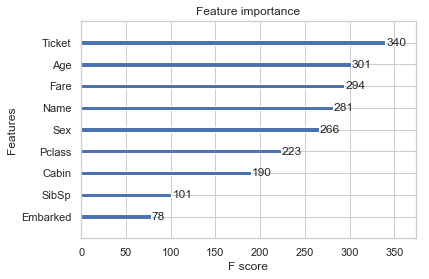

In [81]:
plt.figure(figsize=(12,8))
xgb.plot_importance(model5, max_num_features=10);

## Step 6 : Model Ensembling

Lets create a simple blender. Other options to extend are stacking / majority voting / rank averaging etc. 

In [84]:
models = [model1, model2, model3, model4, model5]
preds = np.zeros(shape=(xtest.shape[0],))
for model in models:
    pred = model.predict(xtest)/ len(models)
    preds += pred
preds[:100]

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0. , 0.2, 0. , 0. , 0.6, 0. , 0.8, 0. , 0.6, 0. , 0. , 0. , 1. ,
       0. , 1. , 0.8, 0. , 0. , 0.2, 0.6, 0. , 0.4, 1. , 0.2, 1. , 0. ,
       1. , 0. , 0.4, 0. , 0. , 0. , 0.4, 0. , 0.2, 0. , 0.2, 0.4, 0. ,
       0.6, 0. , 0.2, 0. , 1. , 1. , 0. , 0. , 0. , 1. , 0.6, 0.4, 0.2,
       1. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0.8, 0.4,
       1. , 0.8, 0. , 0. , 1. , 1. , 0. , 0.6, 0. , 1. , 0.2, 0. , 0.8,
       0. , 1. , 0.2, 0.4, 0. , 0. , 0. , 0. , 0.8, 0.6, 1. , 0.8, 0.2,
       0. , 1. , 0. , 0.4, 0. , 1. , 0. , 0.4, 0. ])

## Step 7 : Create Submission File

Finally, create the submission file from the extereme graident boosting model

In [83]:
try:
    pred = model5.predict(xtest)
    sub = pd.DataFrame()
    sub[_id] = test_id
    sub[_target] = pred
    sub.to_csv("baseline_submission.csv", index=False)
    print ("Submission File Generated, here is the snapshot: ")
    print (sub.head(10))
except:
    print ("This is a dataset kernel, no need to create a submission file :)")

Submission File Generated, here is the snapshot: 
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
